In [516]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
#데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from copy import copy
#시간관련 라이브러리
from datetime import datetime
from scipy import stats
import scipy.stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from collections import Counter
%autosave 60

Autosaving every 60 seconds


In [517]:
matplotlib.rc("font", family = "AppleGothic")
matplotlib.rc("axes", unicode_minus = False)
db_raw = pd.read_csv("/Users/minseok/Downloads/A1_카드/Card_Spanding.csv", encoding='utf-8')
db_card = pd.read_csv("/Users/minseok/Downloads/A1_카드/Card_Data.csv", encoding = 'utf-8')

In [518]:
# matplotlib.rc("font", family = "Malgun Gothic")
# matplotlib.rc("axes", unicode_minus = False)
# db_raw = pd.read_csv("C:/Users/PIAI/Desktop/A1_카드/Card_Spanding.csv", encoding='utf-8')

In [519]:
#원본데이터(주소 데이터 삭제 - 소비처와 유사한 데이터가 많음)
db_raw = db_raw.drop(columns='주소')

In [520]:
#원본데이터 - 날짜데이터 사용을 위한 데이터 처리
db_raw['카드사용일자']= db_raw['카드사용일자'].astype('str')
db_raw['카드사용일자'] = pd.to_datetime(db_raw['카드사용일자'])

In [521]:
db_raw

,지역,소비처,소비처업종,성별,연령,사용횟수,사용금액,사용카드,카드사용일자
0,종로구,상계2동,자동차정비,여성,42,3,56,82,2020-04-01
1,종로구,혜화동,유통업,여성,43,2,50,61,2020-04-01
2,노원구,"상계6,7동",레저업소,남성,50,2,59,140,2020-04-01
3,종로구,"종로5,6가동",레저업소,남성,45,3,56,104,2020-04-01
4,종로구,중계4동,음료식품,여성,38,2,57,103,2020-04-01
...,...,...,...,...,...,...,...,...,...
187517,노원구,상계10동,서적문구,여성,30,5,56,212,2021-02-28
187518,노원구,상계10동,의료기관,남성,60,5,80,4,2021-02-28
187519,노원구,상계10동,요식업소,여성,60,9,246,163,2021-02-28
187520,노원구,상계10동,요식업소,남성,55,18,203,164,2021-02-28


### 소비처 업종 별 인덱스 정리
0. 자동차정비
1. 유통업
2. 레저업소 
3. 서적문구 
4. 수리서비스 
5. 요식업소 
6. 의복 
7. 보건위생 
8. 광학제품 
9. 신변잡화 
10. 의료기관 
11. 주방용품 
12. 직물
13. 사무통신 
14. 문화취미 
15. 가전 
16. 자동차판매
17. 가구
18. 전기 
19. 음료식품 
20. 연료판매 

### 필요한 함수 정의

In [522]:
#나이대별 구분
def age(x):
        if x >= 20 and x < 30: return '20대'       
        elif x >= 30 and x < 40: return '30대'  
        elif x >= 40 and x < 50: return '40대'  
        elif x >= 50 and x < 60: return '50대'    
        elif x >= 60 and x < 70: return '60대'  
        elif x >= 70 and x < 80: return '70대'
        elif x >= 80 and x < 90: return '80대'
        elif x >= 90 and x < 100: return '90대'
        elif x>= 100: return '100세 이상'  
            

# 카드 종류 구분(0 ~ 86 : 체크카드, 87 ~ 262 : 신용카드)
def style(x):
    if x >= 0 and x <= 86: return '체크카드'
    elif x > 86: return '신용카드'
    

# 일자별 계절분류 3~5봄, 6~8 여름 9~11 가을 12~2겨울

def season(x) :
    if x>=3 and x <= 5: return '봄'
    elif x >= 6 and x <= 8: return '여름'
    elif x >= 9 and x <= 11: return '가을'
    elif x == 12 or x < 3: return '겨울'

def quater(x):
    if x <= 3: return 1
    elif x >=4 and x<=6: return 2
    elif x >=7 and x<=9: return 3
    elif x >=1 and x<=12: return 4

In [523]:
# 이상치제거 코드
# q1=db_jong['사용금액'].quantile(0.25)
# q2=db_jong['사용금액'].quantile(0.5)
# q3=db_jong['사용금액'].quantile(0.75)
# iqr=q3-q1
# condition=db_jong['사용금액']>q3+1.5*iqr
# db_jong[condition]
# a=db_jong[condition].index
# db_jong.drop(a,inplace=True)
# db_jong.reset_index(drop=True, inplace = True)

# 파생변수 생성
> 사용금액 / 사용횟수 = 횟수당금액

In [524]:
# 가설 및 파생변수 설정에 필요할 것으로 예상되는 변수 선언
# 파생변수 1. 횟수당 금액
db_raw['횟수당금액'] = (db_raw['사용금액'] / db_raw['사용횟수']).round(2)
# 파생변수 2. 월별, 계절별, 분기별 분석할 예정
db_raw['월'] = db_raw['카드사용일자'].dt.month

# 계절별
db_raw['계절'] = db_raw['월'].apply(season)

# 분기별
db_raw['분기'] = db_raw['월'].apply(quater)

# 연령별
db_raw['연령별'] = db_raw['연령'].apply(age)

# 파생변수 3. 사용카드 혜택 유형 그룹화
# 지역에따른 분석
db_location = copy(db_raw)

#성별에 따른 분석
db_gender = copy(db_raw)

#연령에 따른 분석
db_age = copy(db_raw)

#날짜에 따른 분석
db_date = copy(db_raw)

# 카드 유형에 따른 분석
db_style = copy(db_raw)

# 돈 관련data_혜택.head()
db_money = copy(db_raw)

# 카드 혜택에 따른 분석
df_merge = copy(db_raw)
df_merge = pd.merge(db_raw, db_card, how='left', left_on = '사용카드', right_on = 'Card_ID')

In [525]:
db_raw

,지역,소비처,소비처업종,성별,연령,사용횟수,사용금액,사용카드,카드사용일자,횟수당금액,월,계절,분기,연령별
0,종로구,상계2동,자동차정비,여성,42,3,56,82,2020-04-01,18.67,4,봄,2,40대
1,종로구,혜화동,유통업,여성,43,2,50,61,2020-04-01,25.00,4,봄,2,40대
2,노원구,"상계6,7동",레저업소,남성,50,2,59,140,2020-04-01,29.50,4,봄,2,50대
3,종로구,"종로5,6가동",레저업소,남성,45,3,56,104,2020-04-01,18.67,4,봄,2,40대
4,종로구,중계4동,음료식품,여성,38,2,57,103,2020-04-01,28.50,4,봄,2,30대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187517,노원구,상계10동,서적문구,여성,30,5,56,212,2021-02-28,11.20,2,겨울,1,30대
187518,노원구,상계10동,의료기관,남성,60,5,80,4,2021-02-28,16.00,2,겨울,1,60대
187519,노원구,상계10동,요식업소,여성,60,9,246,163,2021-02-28,27.33,2,겨울,1,60대
187520,노원구,상계10동,요식업소,남성,55,18,203,164,2021-02-28,11.28,2,겨울,1,50대


# 데이터 확인
1) 남녀빈도 비율
2) 연령대 빈도 분포
3) 노원구 & 종로구 소비 횟수
4) 소비처 업종 종류, 빈도
5) 사용카드 빈도 분포
6) 노원구 & 종로구 사용 금액 차이
7) 성별 소비금액 차이
8) 성별 사용하는 카드 혜택 빈도 수
9) 연령대 별 사용 금액 차트
10) 연령대 별 사용하는 카드 혜택 빈도 수

## 1) 남녀 빈도 비율 파이차트

In [526]:
num_m = len(db_gender[db_gender['성별'].isin(['남성'])])
num_w = len(db_gender[db_gender['성별'].isin(['여성'])])
num_gender = [num_m, num_w]

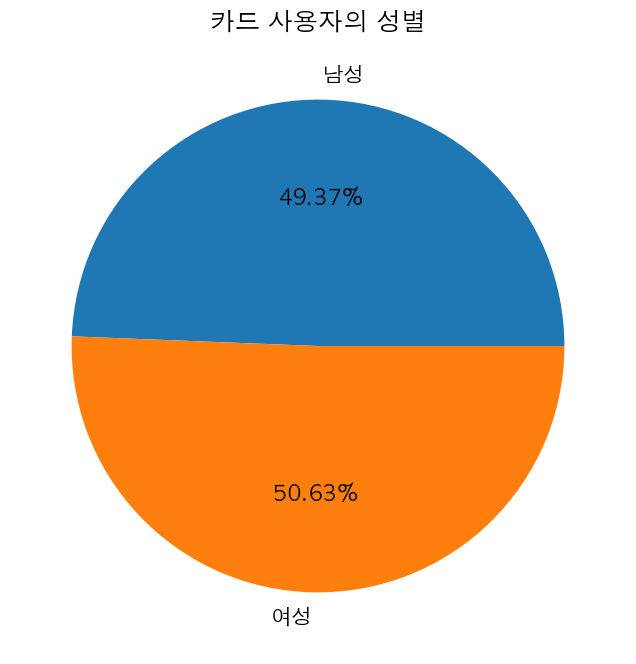

In [527]:
plt.rc('font', size=15)        # 기본 폰트 크기
plt.figure(figsize = (8, 8))
plt.pie(num_gender, labels=['남성','여성'], autopct='%.2f%%')
plt.title('카드 사용자의 성별')
plt.show()

 ## 2) 연령대 빈도 분포 파이차트

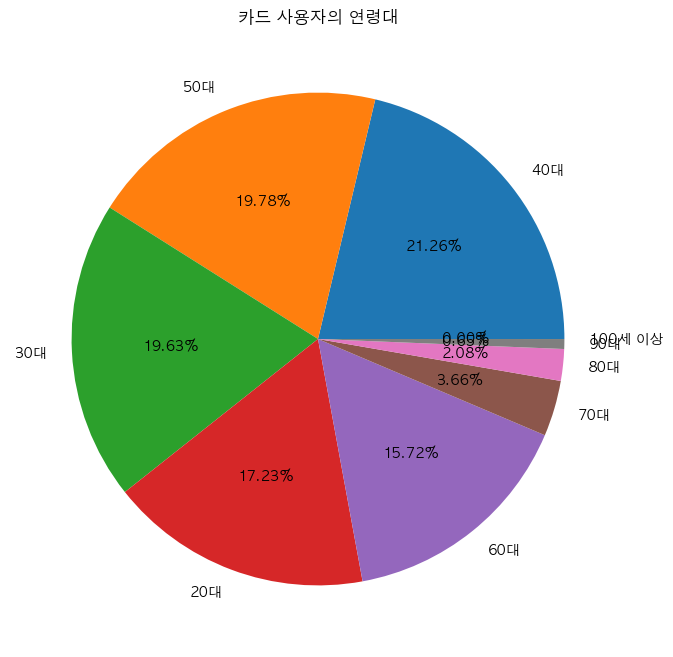

In [528]:
db_age['연령'] = db_age['연령'].apply(age)
age_labels = db_age['연령'].value_counts().index.tolist()
age_ratio = db_age['연령'].value_counts().values.tolist()

plt.rc('font', size=10)
plt.figure(figsize = (8,8))
plt.pie(age_ratio, labels=age_labels, autopct='%.2f%%')
plt.title('카드 사용자의 연령대')plt.title('혜택분야별 카드 결제 횟수')

## 3) 노원구 & 종로구 소비 횟수 차이

In [529]:
db_jong = copy(db_location)
db_no = copy(db_location)

In [530]:
db_jong = db_jong[db_jong['지역'].isin(['종로구'])]
db_jong.reset_index(drop=True, inplace = True)

db_no = db_no[db_no['지역'].isin(['노원구'])]
db_no.reset_index(drop = True, inplace = True)

In [531]:
loc_scale = [len(db_jong), len(db_no)]
loc_scale

[84888, 102634]

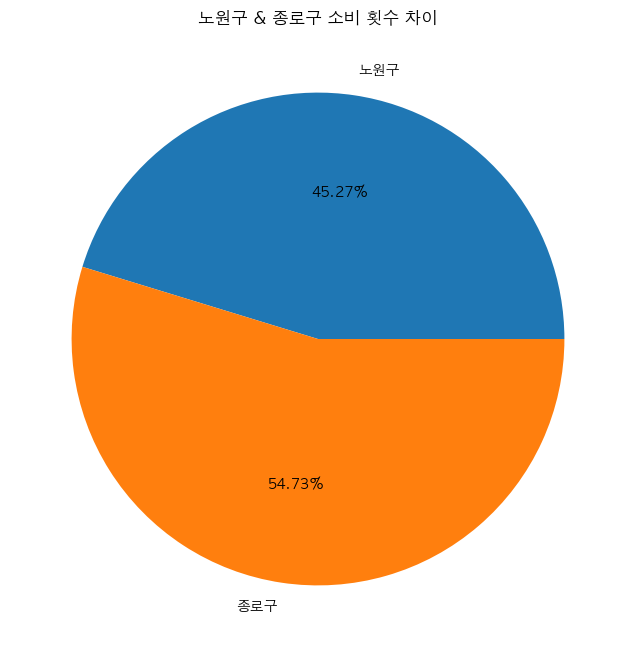

In [532]:
plt.rc('font', size=10)
plt.figure(figsize = (8,8))
plt.pie(loc_scale, labels=['노원구','종로구'], autopct='%.2f%%')
plt.title('노원구 & 종로구 소비 횟수 차이')
plt.show()

In [533]:
val = [len(db_raw[db_raw['소비처업종'].isin(['자동차정비'])]),
      len(db_raw[db_raw['소비처업종'].isin(['유통업'])]),
      len(db_raw[db_raw['소비처업종'].isin(['레저업소'])]),
      len(db_raw[db_raw['소비처업종'].isin(['음료식품'])]),
      len(db_raw[db_raw['소비처업종'].isin(['서적문구'])]),
      len(db_raw[db_raw['소비처업종'].isin(['수리서비스'])]),
      len(db_raw[db_raw['소비처업종'].isin(['요식업소'])]),
      len(db_raw[db_raw['소비처업종'].isin(['의복'])]),
      len(db_raw[db_raw['소비처업종'].isin(['보건위생'])]),
      len(db_raw[db_raw['소비처업종'].isin(['광학제품'])]),
      len(db_raw[db_raw['소비처업종'].isin(['신변잡화'])]),
      len(db_raw[db_raw['소비처업종'].isin(['연료판매'])]),
      len(db_raw[db_raw['소비처업종'].isin(['의료기관'])]),
      len(db_raw[db_raw['소비처업종'].isin(['주방용품'])]),
      len(db_raw[db_raw['소비처업종'].isin(['직물'])]),
      len(db_raw[db_raw['소비처업종'].isin(['사무통신'])]),
      len(db_raw[db_raw['소비처업종'].isin(['문화취미'])]),
      len(db_raw[db_raw['소비처업종'].isin(['가전'])]),
      len(db_raw[db_raw['소비처업종'].isin(['자동차판매'])]),
      len(db_raw[db_raw['소비처업종'].isin(['가구'])]),
      len(db_raw[db_raw['소비처업종'].isin(['전기'])])]

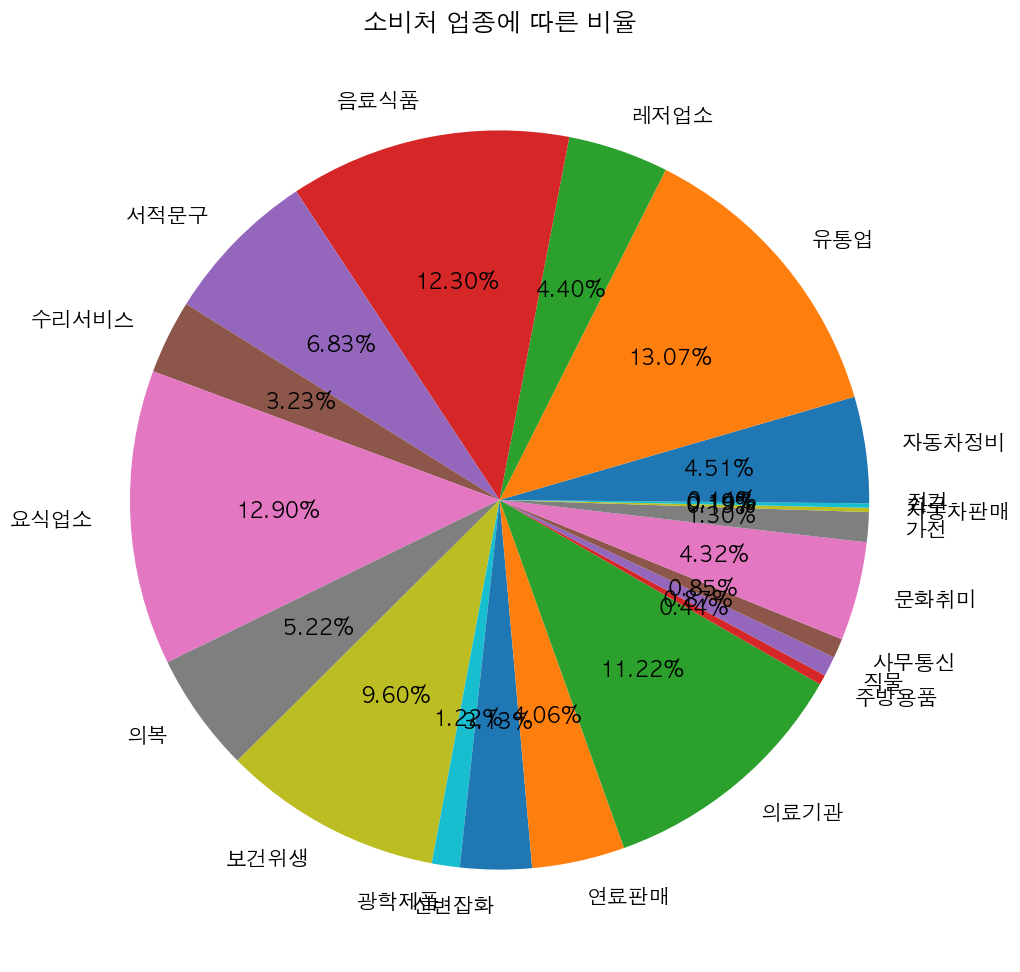

In [534]:
plt.rc('font', size=15)
plt.figure(figsize = (12,12))
plt.pie(val, labels=db_raw['소비처업종'].unique(), autopct='%.2f%%')
plt.title('소비처 업종에 따른 비율')
plt.show()

## 4) 소비처 업종 종류 및 빈도

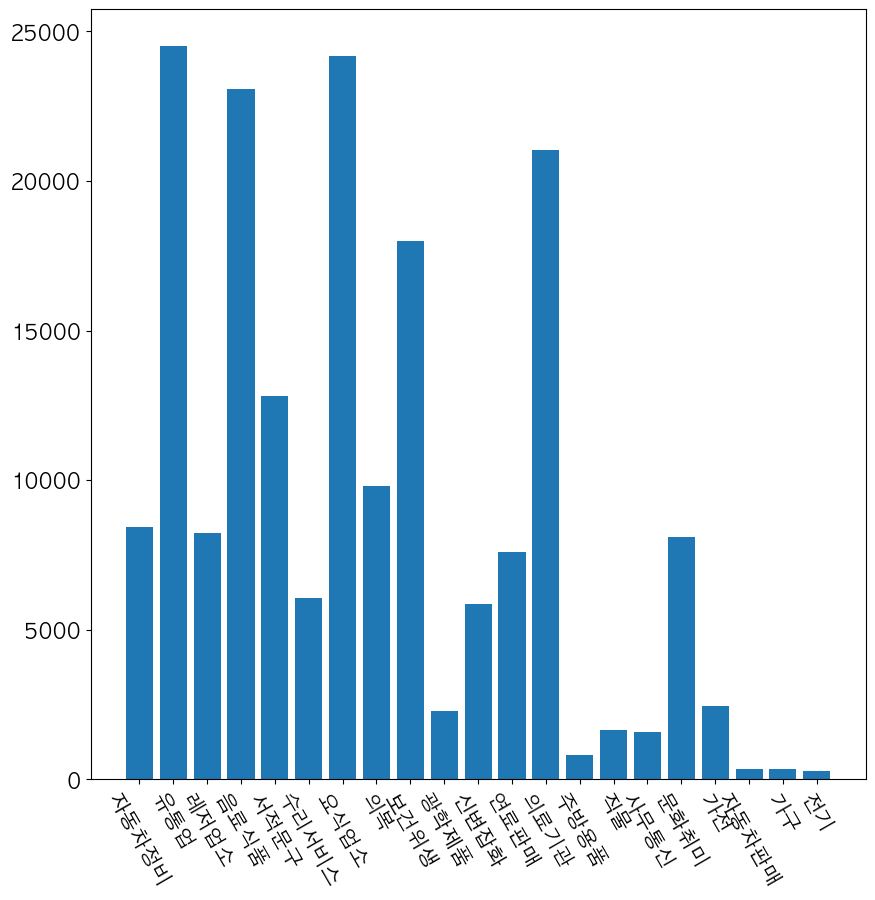

In [535]:
plt.figure(figsize = (10,10))
plt.bar(db_raw['소비처업종'].unique(), val)
plt.xticks(rotation = -60)
plt.show()

## 5) 사용카드 빈도 분포 확인

In [536]:
df_c = copy(df_merge)
use_c = df_c['혜택분야'].value_counts()

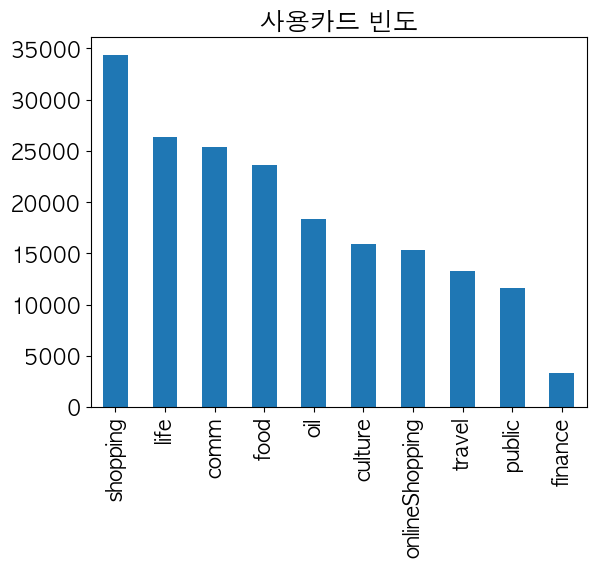

In [537]:
use_c.plot.bar()
plt.title("사용카드 빈도")
plt.show()

## 6) 노원구 & 종로구 사용 금액 차이

In [538]:
db_location

,지역,소비처,소비처업종,성별,연령,사용횟수,사용금액,사용카드,카드사용일자,횟수당금액,월,계절,분기,연령별
0,종로구,상계2동,자동차정비,여성,42,3,56,82,2020-04-01,18.67,4,봄,2,40대
1,종로구,혜화동,유통업,여성,43,2,50,61,2020-04-01,25.00,4,봄,2,40대
2,노원구,"상계6,7동",레저업소,남성,50,2,59,140,2020-04-01,29.50,4,봄,2,50대
3,종로구,"종로5,6가동",레저업소,남성,45,3,56,104,2020-04-01,18.67,4,봄,2,40대
4,종로구,중계4동,음료식품,여성,38,2,57,103,2020-04-01,28.50,4,봄,2,30대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187517,노원구,상계10동,서적문구,여성,30,5,56,212,2021-02-28,11.20,2,겨울,1,30대
187518,노원구,상계10동,의료기관,남성,60,5,80,4,2021-02-28,16.00,2,겨울,1,60대
187519,노원구,상계10동,요식업소,여성,60,9,246,163,2021-02-28,27.33,2,겨울,1,60대
187520,노원구,상계10동,요식업소,남성,55,18,203,164,2021-02-28,11.28,2,겨울,1,50대


In [539]:
no_price = db_location[db_location['지역'].isin(['노원구'])]['사용금액'].sum()
jong_price = db_location[db_location['지역'].isin(['종로구'])]['사용금액'].sum()

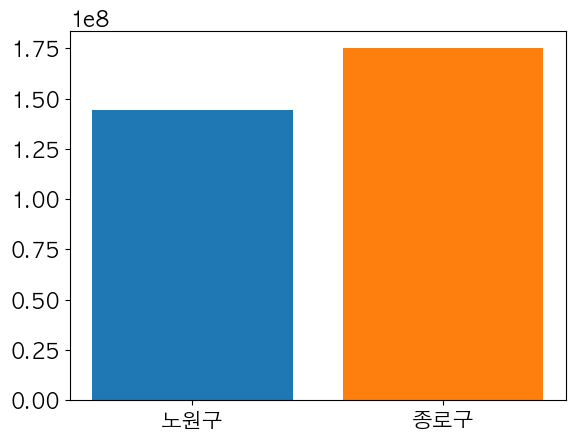

In [540]:
#이상치 처리전 금액 총합
plt.bar(['노원구'], no_price)
plt.bar(['종로구'], jong_price)
plt.show()

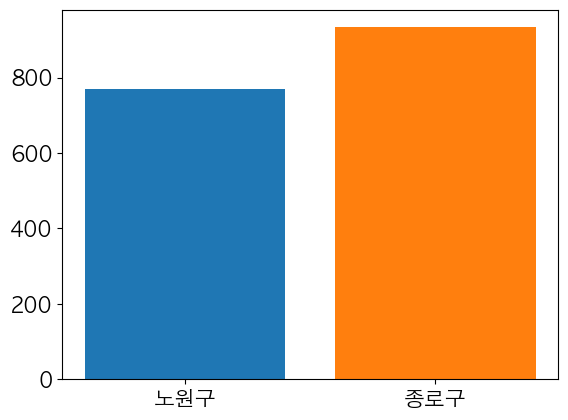

In [541]:
#이상치 처리전 평균 금액
plt.bar(['노원구'], no_price/len(db_location['사용금액']))
plt.bar(['종로구'], jong_price/len(db_location['사용금액']))
plt.show()

In [542]:
db_location_per = copy(db_location)

In [543]:
#횟수당 금액 이상치 처리 및 inf값 제외
q1=db_location_per['횟수당금액'].quantile(0.25)
q2=db_location_per['횟수당금액'].quantile(0.5)
q3=db_location_per['횟수당금액'].quantile(0.75)
iqr=q3-q1
condition=db_location_per['횟수당금액']>q3+1.5*iqr
db_location_per[condition]
a=db_location_per[condition].index
db_location_per.drop(a,inplace=True)
db_location_per.reset_index(drop=True, inplace = True)

#inf값 제거
db_location_per.replace([np.inf, -np.inf], np.nan)
db_location_per.dropna()
db_location_per.reset_index(drop=True, inplace = True)

In [544]:
no_price = db_location_per[db_location_per['지역'].isin(['노원구'])]['횟수당금액'].sum()
jong_price = db_location_per[db_location_per['지역'].isin(['종로구'])]['횟수당금액'].sum()

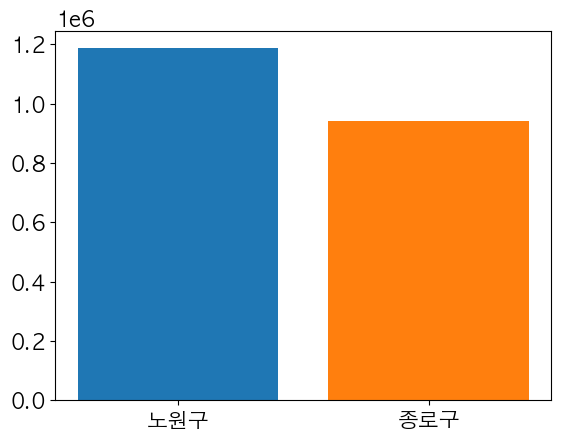

In [545]:
#이상치 처리 후 횟수당 금액
plt.bar(['노원구'], no_price)
plt.bar(['종로구'], jong_price)
plt.show()

In [546]:
#이상치 처리 후
q1=db_location['사용금액'].quantile(0.25)
q2=db_location['사용금액'].quantile(0.5)
q3=db_location['사용금액'].quantile(0.75)
iqr=q3-q1
condition=db_location['사용금액']>q3+1.5*iqr
db_location[condition]
a=db_location[condition].index
db_location.drop(a,inplace=True)
db_location.reset_index(drop=True, inplace = True)

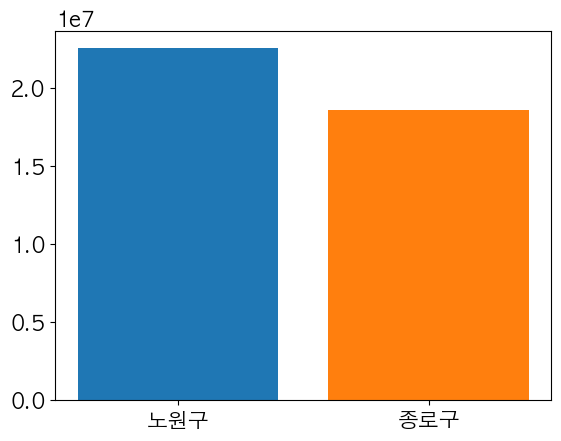

In [547]:
no_price = db_location[db_location['지역'].isin(['노원구'])]['사용금액'].sum()
jong_price = db_location[db_location['지역'].isin(['종로구'])]['사용금액'].sum()
plt.bar(['노원구'], no_price)
plt.bar(['종로구'], jong_price)
plt.show()

## 7) 성별 소비금액 차이

In [548]:
db_gender

,지역,소비처,소비처업종,성별,연령,사용횟수,사용금액,사용카드,카드사용일자,횟수당금액,월,계절,분기,연령별
0,종로구,상계2동,자동차정비,여성,42,3,56,82,2020-04-01,18.67,4,봄,2,40대
1,종로구,혜화동,유통업,여성,43,2,50,61,2020-04-01,25.00,4,봄,2,40대
2,노원구,"상계6,7동",레저업소,남성,50,2,59,140,2020-04-01,29.50,4,봄,2,50대
3,종로구,"종로5,6가동",레저업소,남성,45,3,56,104,2020-04-01,18.67,4,봄,2,40대
4,종로구,중계4동,음료식품,여성,38,2,57,103,2020-04-01,28.50,4,봄,2,30대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187517,노원구,상계10동,서적문구,여성,30,5,56,212,2021-02-28,11.20,2,겨울,1,30대
187518,노원구,상계10동,의료기관,남성,60,5,80,4,2021-02-28,16.00,2,겨울,1,60대
187519,노원구,상계10동,요식업소,여성,60,9,246,163,2021-02-28,27.33,2,겨울,1,60대
187520,노원구,상계10동,요식업소,남성,55,18,203,164,2021-02-28,11.28,2,겨울,1,50대


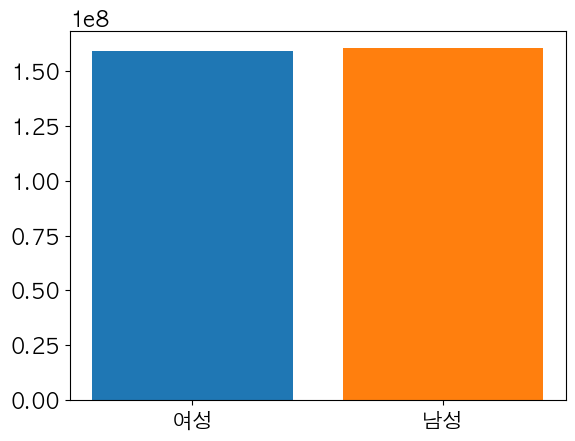

In [549]:
#이상치 처리 전 총사용금액
price_w = db_gender[db_gender['성별'].isin(['여성'])]['사용금액'].sum()
price_m = db_gender[db_gender['성별'].isin(['남성'])]['사용금액'].sum()
plt.bar('여성', price_w)
plt.bar('남성', price_m)
plt.show()

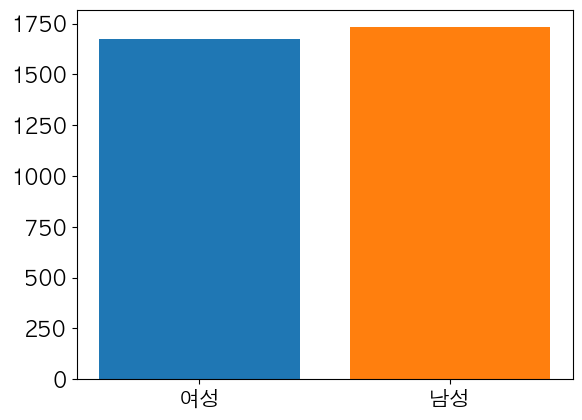

In [550]:
#이상치 처리 전 평균 사용금액
price_w = db_gender[db_gender['성별'].isin(['여성'])]['사용금액'].mean()
price_m = db_gender[db_gender['성별'].isin(['남성'])]['사용금액'].mean()
plt.bar('여성', price_w)
plt.bar('남성', price_m)
plt.show()

In [551]:
#이상치 처리
q1=db_gender['사용금액'].quantile(0.25)
q2=db_gender['사용금액'].quantile(0.5)
q3=db_gender['사용금액'].quantile(0.75)
iqr=q3-q1
condition=db_gender['사용금액']>q3+1.5*iqr
db_gender[condition]
a=db_gender[condition].index
db_gender.drop(a,inplace=True)
db_gender.reset_index(drop=True, inplace = True)

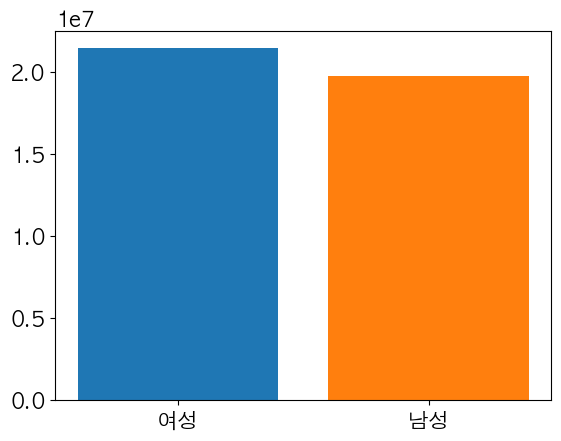

In [552]:
#이상치 처리 후 총사용금액
price_w = db_gender[db_gender['성별'].isin(['여성'])]['사용금액'].sum()
price_m = db_gender[db_gender['성별'].isin(['남성'])]['사용금액'].sum()
plt.bar('여성', price_w)
plt.bar('남성', price_m)
plt.show()

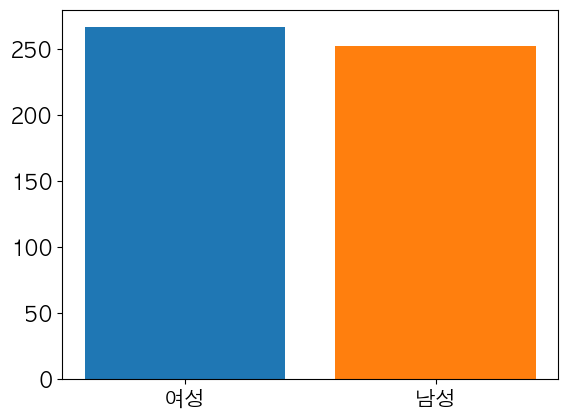

In [553]:
#이상치 처리 후 평균 사용금액
price_w = db_gender[db_gender['성별'].isin(['여성'])]['사용금액'].mean()
price_m = db_gender[db_gender['성별'].isin(['남성'])]['사용금액'].mean()
plt.bar('여성', price_w)
plt.bar('남성', price_m)
plt.show()

## 8) 성별 사용하는 카드 혜택 빈도 수

In [554]:
use_gender = copy(df_merge)

In [555]:
use_w = use_gender[use_gender['성별'].isin(['여성'])]
use_w.reset_index(drop=True, inplace = True)
use_m = use_gender[use_gender['성별'].isin(['남성'])]
use_m.reset_index(drop=True, inplace = True)

In [556]:
tmp_w = use_w['혜택분야'].value_counts()
tmp_m = use_m['혜택분야'].value_counts()
tmp_w = tmp_w.to_frame()
tmp_m = tmp_m.to_frame()

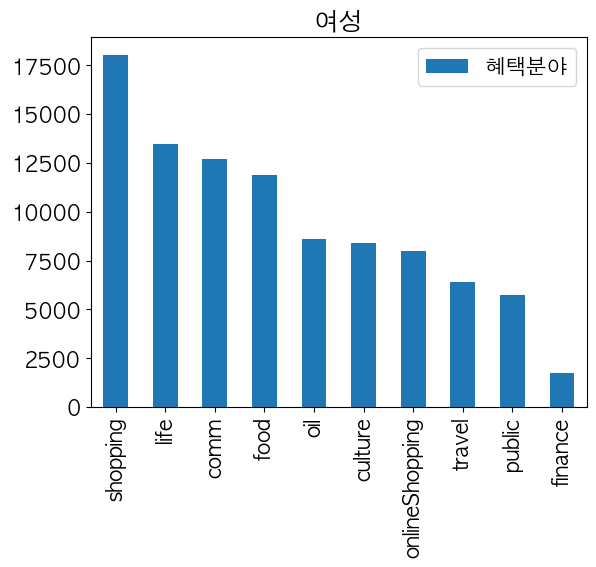

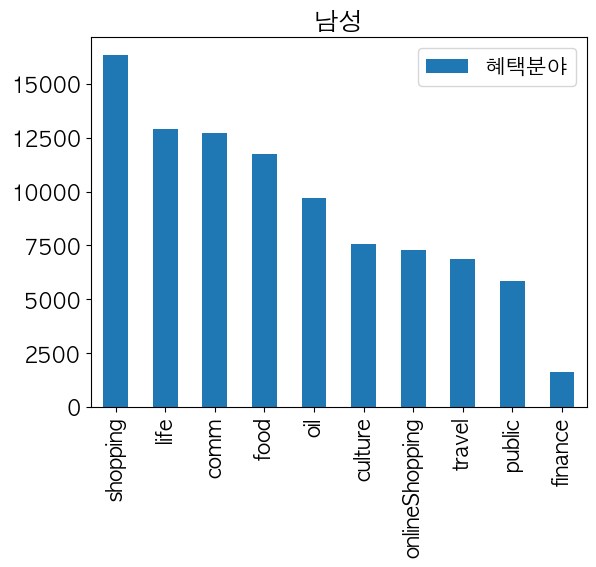

In [557]:
tmp_w.plot.bar()
plt.title("여성")
tmp_m.plot.bar()
plt.title("남성")
plt.show()

## 9) 연령대 별 사용 금액

In [558]:
db_age

,지역,소비처,소비처업종,성별,연령,사용횟수,사용금액,사용카드,카드사용일자,횟수당금액,월,계절,분기,연령별
0,종로구,상계2동,자동차정비,여성,40대,3,56,82,2020-04-01,18.67,4,봄,2,40대
1,종로구,혜화동,유통업,여성,40대,2,50,61,2020-04-01,25.00,4,봄,2,40대
2,노원구,"상계6,7동",레저업소,남성,50대,2,59,140,2020-04-01,29.50,4,봄,2,50대
3,종로구,"종로5,6가동",레저업소,남성,40대,3,56,104,2020-04-01,18.67,4,봄,2,40대
4,종로구,중계4동,음료식품,여성,30대,2,57,103,2020-04-01,28.50,4,봄,2,30대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187517,노원구,상계10동,서적문구,여성,30대,5,56,212,2021-02-28,11.20,2,겨울,1,30대
187518,노원구,상계10동,의료기관,남성,60대,5,80,4,2021-02-28,16.00,2,겨울,1,60대
187519,노원구,상계10동,요식업소,여성,60대,9,246,163,2021-02-28,27.33,2,겨울,1,60대
187520,노원구,상계10동,요식업소,남성,50대,18,203,164,2021-02-28,11.28,2,겨울,1,50대


In [559]:
_20대 = (db_age[db_age['연령'].isin(['20대'])])
_30대 = (db_age[db_age['연령'].isin(['30대'])])
_40대 = (db_age[db_age['연령'].isin(['40대'])])
_50대 = (db_age[db_age['연령'].isin(['50대'])])
_60대 = (db_age[db_age['연령'].isin(['60대'])])
_70대 = (db_age[db_age['연령'].isin(['70대'])])
_80대 = (db_age[db_age['연령'].isin(['80대'])])
_90대 = (db_age[db_age['연령'].isin(['90대'])])
_100세이상 = (db_age[db_age['연령'].isin(['100세 이상'])])

<BarContainer object of 9 artists>

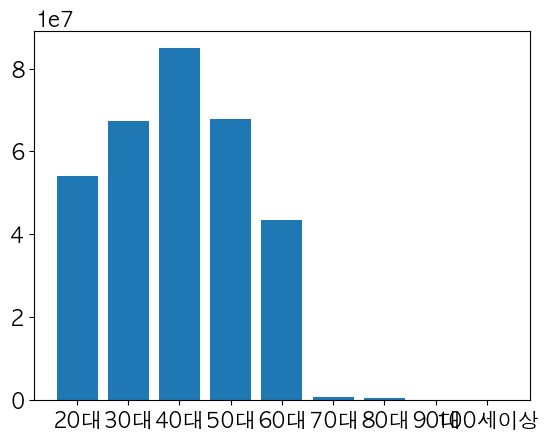

In [562]:
age_value = [_20대['사용금액'].sum(), _30대['사용금액'].sum(),
             _40대['사용금액'].sum(), _50대['사용금액'].sum(),
             _60대['사용금액'].sum(), _70대['사용금액'].sum(),
             _80대['사용금액'].sum(), _90대['사용금액'].sum(),
             _100세이상['사용금액'].sum()]
age_col = ['20대', '30대', '40대', '50대', '60대', '70대', '80대','90대','100세이상']

#이상치 처리전
plt.bar(age_col, age_value)

In [563]:
#이상치 처리 후
q1=db_age['사용금액'].quantile(0.25)
q2=db_age['사용금액'].quantile(0.5)
q3=db_age['사용금액'].quantile(0.75)
iqr=q3-q1
condition=db_age['사용금액']>q3+1.5*iqr
db_age[condition]
a=db_age[condition].index
db_age.drop(a,inplace=True)
db_age.reset_index(drop=True, inplace = True)

<BarContainer object of 9 artists>

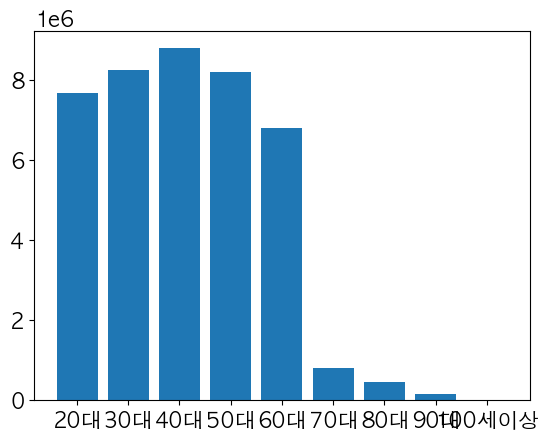

In [564]:
_20대 = (db_age[db_age['연령'].isin(['20대'])])
_30대 = (db_age[db_age['연령'].isin(['30대'])])
_40대 = (db_age[db_age['연령'].isin(['40대'])])
_50대 = (db_age[db_age['연령'].isin(['50대'])])
_60대 = (db_age[db_age['연령'].isin(['60대'])])
_70대 = (db_age[db_age['연령'].isin(['70대'])])
_80대 = (db_age[db_age['연령'].isin(['80대'])])
_90대 = (db_age[db_age['연령'].isin(['90대'])])
_100세이상 = (db_age[db_age['연령'].isin(['100세 이상'])])

age_value = [_20대['사용금액'].sum(), _30대['사용금액'].sum(),
             _40대['사용금액'].sum(), _50대['사용금액'].sum(),
             _60대['사용금액'].sum(), _70대['사용금액'].sum(),
             _80대['사용금액'].sum(), _90대['사용금액'].sum(),
             _100세이상['사용금액'].sum()]
age_col = ['20대', '30대', '40대', '50대', '60대', '70대', '80대','90대','100세이상']

#이상치 처리전
plt.bar(age_col, age_value)

## 10) 연령대 별 사용하는 카드 혜택 빈도 수

In [567]:
age_pro = copy(df_merge)

In [573]:
age_pro['연령대'] = age_pro['연령'].apply(age)
age_pro['연령대'].value_counts()

40대        39876
50대        37083
30대        36807
20대        32307
60대        29477
70대         6860
80대         3897
90대         1212
100세 이상        3
Name: 연령대, dtype: int64

In [575]:
pro40 = age_pro[age_pro['연령대'].isin(['40대'])]
pro50 = age_pro[age_pro['연령대'].isin(['50대'])]
pro60 = age_pro[age_pro['연령대'].isin(['60대'])]
pro70 = age_pro[age_pro['연령대'].isin(['70대'])]
pro80 = age_pro[age_pro['연령대'].isin(['80대'])]
pro90 = age_pro[age_pro['연령대'].isin(['90대'])]
pro100 = age_pro[age_pro['연령대'].isin(['100세 이상'])]

In [581]:
c40 = pro40['혜택분야'].value_counts()
c50 = pro50['혜택분야'].value_counts()
c60 = pro60['혜택분야'].value_counts()
c70 = pro70['혜택분야'].value_counts()
c80 = pro80['혜택분야'].value_counts()
c90 = pro90['혜택분야'].value_counts()
c100 = pro100['혜택분야'].value_counts()

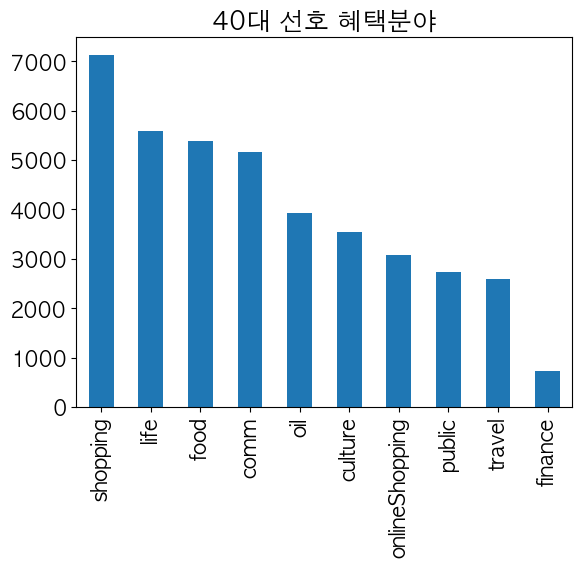

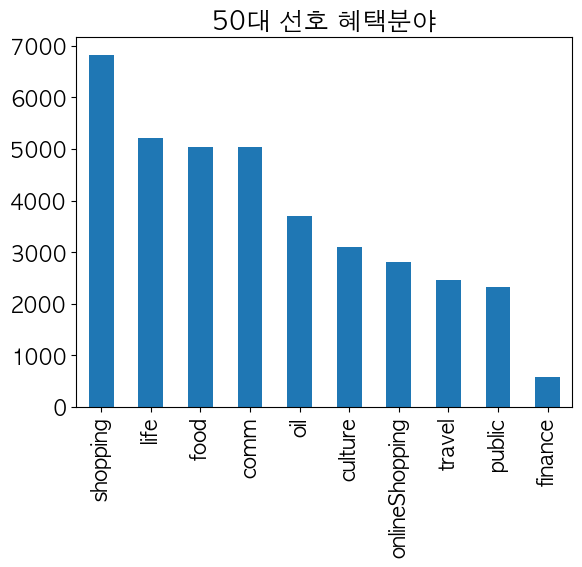

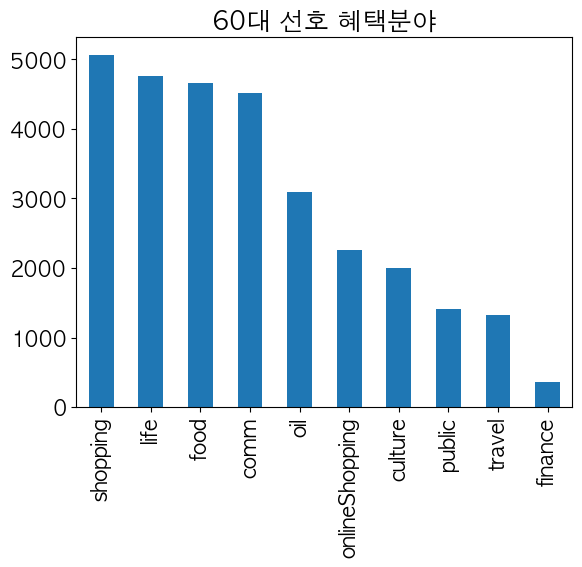

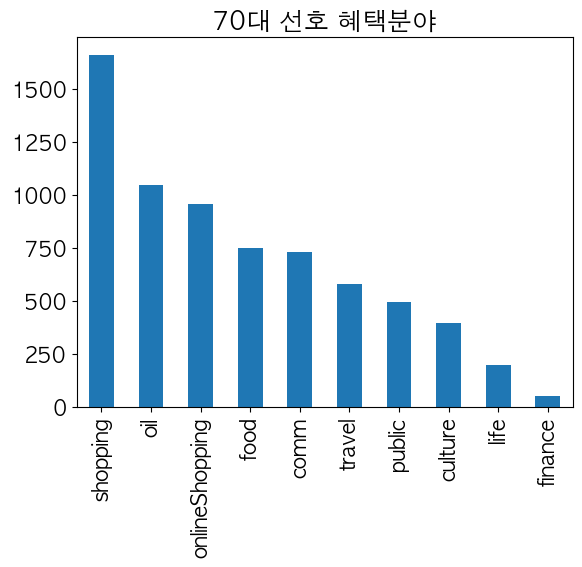

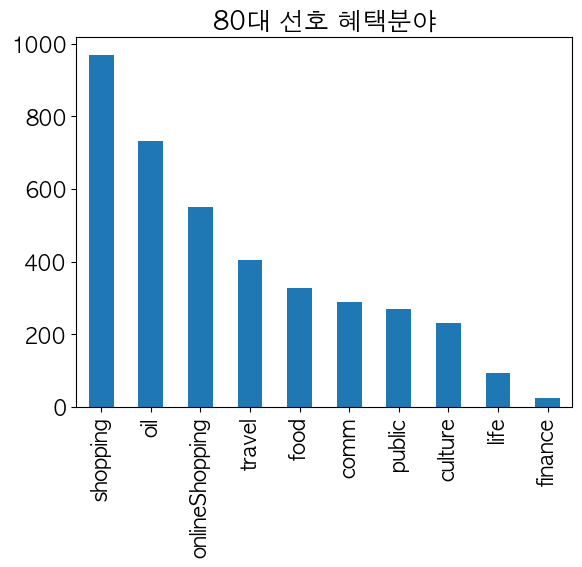

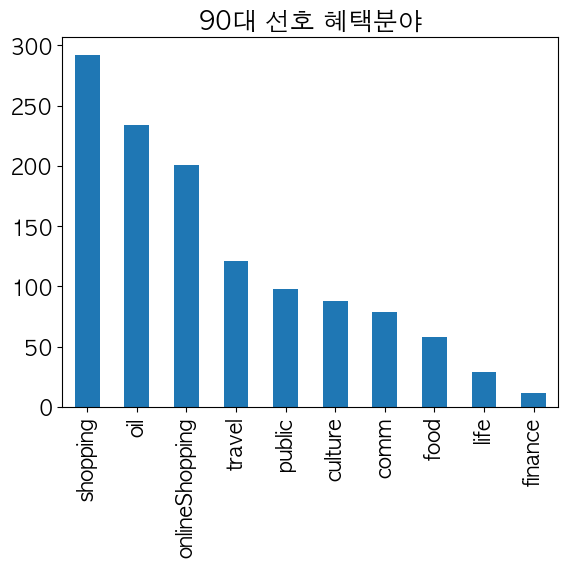

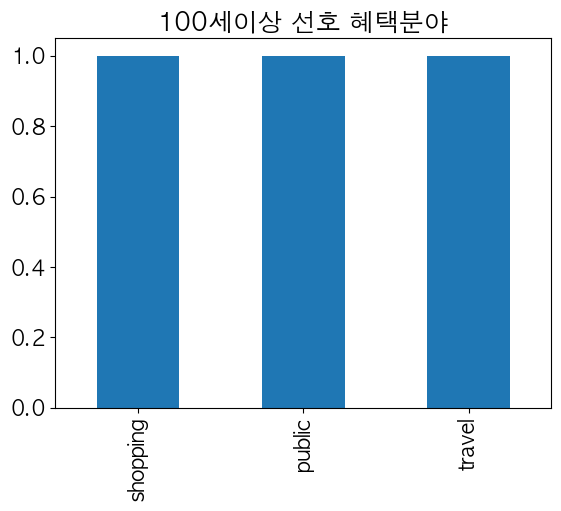

In [592]:
c40.plot.bar()
plt.title("40대 선호 혜택분야")
plt.show()

c50.plot.bar()
plt.title("50대 선호 혜택분야")
plt.show()

c60.plot.bar()
plt.title("60대 선호 혜택분야")
plt.show()

c70.plot.bar()
plt.title("70대 선호 혜택분야")
plt.show()


c80.plot.bar()
plt.title("80대 선호 혜택분야")
plt.show()


c90.plot.bar()
plt.title("90대 선호 혜택분야")
plt.show()

c100.plot.bar()
plt.title("100세이상 선호 혜택분야")
plt.show()

# 가설분석
 1) 연령대에 따라 소비혜택
 2) 성별에 따른 소비혜택
 3) 계절, 월별 소비혜택 사용량
 4) 시장상황에 따른 소비 패턴

## 가설 1) 연령대에 따라 소비혜택이 다를 것이다.

 ## 가설 2) 성별에 따른 소비혜택이 다를 것이다.

## 가설 3) 계절, 월별 소비혜택 사용량이 다를 것이다.

## 가설 4) 시장상황에 따른 소비 패턴

inf